<a href="https://colab.research.google.com/github/Zizi32/FaceSwappingusingOpenCV/blob/main/FaceswappingusingOpenCV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[(80, 311), (80, 357), (83, 405), (88, 454), (96, 502), (114, 546), (144, 580), (180, 607), (226, 616), (278, 611), (335, 591), (391, 568), (434, 531), (464, 486), (479, 433), (487, 377), (494, 321), (109, 259), (126, 238), (154, 235), (183, 239), (212, 248), (283, 255), (321, 244), (359, 240), (397, 247), (427, 271), (241, 298), (237, 327), (232, 354), (227, 383), (201, 418), (215, 423), (230, 427), (250, 425), (270, 421), (141, 301), (159, 293), (181, 294), (199, 309), (178, 313), (156, 311), (309, 312), (331, 299), (355, 298), (376, 309), (356, 317), (331, 317), (177, 503), (194, 484), (213, 473), (228, 477), (244, 474), (271, 488), (299, 507), (271, 523), (244, 528), (226, 528), (209, 525), (192, 517), (190, 500), (213, 489), (228, 491), (244, 491), (286, 504), (244, 508), (228, 507), (211, 504)]
[(330, 660), (340, 724), (350, 785), (365, 847), (391, 905), (431, 957), (478, 1002), (526, 1044), (583, 1054), (643, 1040), (706, 996), (772, 950), (824, 895), (858, 829), (868, 758), (86

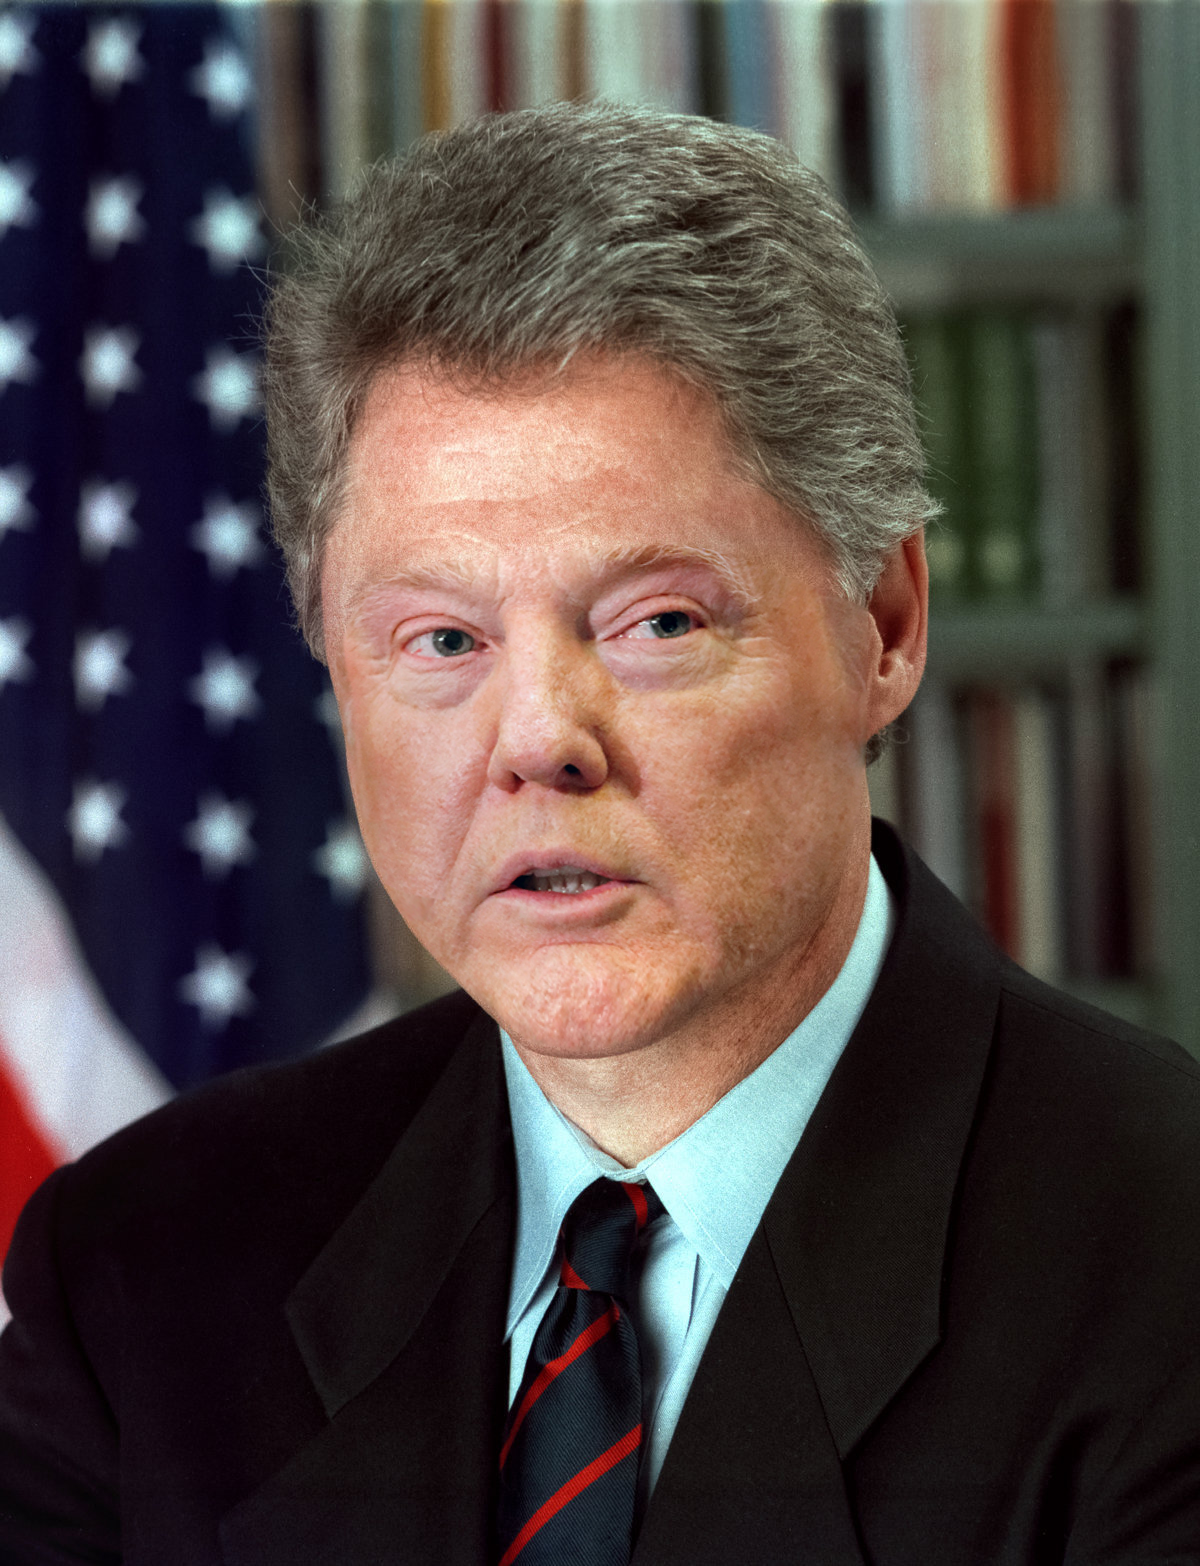

In [ ]:
import sys
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
def readPoints(path) :
   
    img_points = [];
    
    with open(path) as file :
        for line in file :
            a, b = line.split()
            img_points.append((int(a), int(b)))
    
    print(img_points) 
    return img_points

def applyAffineTransform(src, srcTri, dstTri, size) :
    
    warpMat = cv2.getAffineTransform( np.float32(srcTri), np.float32(dstTri) )
  
    dst = cv2.warpAffine( src, warpMat, (size[0], size[1]), None, flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT_101 )

    return dst


def rectContains(rect, point) :
    if point[0] < rect[0] :
        return False
    elif point[1] < rect[1] :
        return False
    elif point[0] > rect[0] + rect[2] :
        return False
    elif point[1] > rect[1] + rect[3] :
        return False
    return True


def calculateDelaunayTriangles(rect, points):
   
    subdiv = cv2.Subdiv2D(rect);
    
  
    for p in points:
        subdiv.insert(p) 
    
    triangleList = subdiv.getTriangleList();
    
    delaunayTri = []
    
    pt = []    
        
    for t in triangleList:        
        pt.append((t[0], t[1]))
        pt.append((t[2], t[3]))
        pt.append((t[4], t[5]))
        
        pt1 = (t[0], t[1])
        pt2 = (t[2], t[3])
        pt3 = (t[4], t[5])        
        
        if rectContains(rect, pt1) and rectContains(rect, pt2) and rectContains(rect, pt3):
            ind = []
           
            for j in range(0, 3):
                for k in range(0, len(points)):                    
                    if(abs(pt[j][0] - points[k][0]) < 1.0 and abs(pt[j][1] - points[k][1]) < 1.0):
                        ind.append(k)    
            if len(ind) == 3:                                                
                delaunayTri.append((ind[0], ind[1], ind[2]))
        
        pt = []        
            
    
    return delaunayTri
        
def warpTriangle(img1, img2, t1, t2) :

    r1 = cv2.boundingRect(np.float32([t1]))
    r2 = cv2.boundingRect(np.float32([t2]))

    t1Rect = [] 
    t2Rect = []
    t2RectInt = []

    for i in range(0, 3):
        t1Rect.append(((t1[i][0] - r1[0]),(t1[i][1] - r1[1])))
        t2Rect.append(((t2[i][0] - r2[0]),(t2[i][1] - r2[1])))
        t2RectInt.append(((t2[i][0] - r2[0]),(t2[i][1] - r2[1])))



    mask = np.zeros((r2[3], r2[2], 3), dtype = np.float32)
    cv2.fillConvexPoly(mask, np.int32(t2RectInt), (1.0, 1.0, 1.0), 16, 0);

 
    img1Rect = img1[r1[1]:r1[1] + r1[3], r1[0]:r1[0] + r1[2]]
    
    size = (r2[2], r2[3])

    img2Rect = applyAffineTransform(img1Rect, t1Rect, t2Rect, size)
    
    img2Rect = img2Rect * mask

    img2[r2[1]:r2[1]+r2[3], r2[0]:r2[0]+r2[2]] = img2[r2[1]:r2[1]+r2[3], r2[0]:r2[0]+r2[2]] * ( (1.0, 1.0, 1.0) - mask )
     
    img2[r2[1]:r2[1]+r2[3], r2[0]:r2[0]+r2[2]] = img2[r2[1]:r2[1]+r2[3], r2[0]:r2[0]+r2[2]] + img2Rect 
    

if __name__ == '__main__' :
   
    file1 = 'donald.jpg'
    file2 = 'bill-clinton.jpg'
    
    img1 = cv2.imread(file1);
    img2 = cv2.imread(file2);
    img1Warped = np.copy(img2);    
   
    points1 = readPoints(file1 + '.txt')
    points2 = readPoints(file2 + '.txt')    
    
    hull1 = []
    hull2 = []

    hullIndex = cv2.convexHull(np.array(points2), returnPoints = False)
          
    for i in range(0, len(hullIndex)):
        hull1.append(points1[int(hullIndex[i])])
        hull2.append(points2[int(hullIndex[i])])
    
 
    sizeImg2 = img2.shape    
    rect = (0, 0, sizeImg2[1], sizeImg2[0])
     
    dt = calculateDelaunayTriangles(rect, hull2)
    
    if len(dt) == 0:
        quit()
   
    for i in range(0, len(dt)):
        t1 = []
        t2 = []
       
        for j in range(0, 3):
            t1.append(hull1[dt[i][j]])
            t2.append(hull2[dt[i][j]])
        
        warpTriangle(img1, img1Warped, t1, t2)

    hull8U = []
    for i in range(0, len(hull2)):
        hull8U.append((hull2[i][0], hull2[i][1]))
    
    mask = np.zeros(img2.shape, dtype = img2.dtype)  
    
    cv2.fillConvexPoly(mask, np.int32(hull8U), (255, 255, 255))
    
    r = cv2.boundingRect(np.float32([hull2]))    
    
    center = ((r[0]+int(r[2]/2), r[1]+int(r[3]/2)))
        

    swapped_image = cv2.seamlessClone(np.uint8(img1Warped), img2, mask, center, cv2.NORMAL_CLONE)
    
    cv2_imshow(swapped_image)
  

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving bill-clinton.jpg to bill-clinton.jpg
Saving bill-clinton.jpg.txt to bill-clinton.jpg.txt
Saving donald.jpg to donald.jpg
Saving donald.jpg.txt to donald.jpg.txt
